## Problem 1

In [23]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import matplotlib.pyplot as plt


In [178]:
def LJ(x, N = 100, L=16, eps=1., sigma=1.):
    x1 = np.broadcast_to(x.reshape((N,1,3)), (N,N,3))
    x2 = np.broadcast_to(x.reshape((1,N,3)), (N,N,3))
    R = x2-x1    
    R = (R+L/2.)%L-L/2. # periodic b.c.
    assert np.all(R >= -L/2.) and np.all(R <= L/2.)
    r = np.sqrt(np.sum(R*R, axis=2))+1e-10
    sr = sigma/r
    F0 = 4*eps*(12*sr**12-6*sr**6) 
    F = R*np.broadcast_to((F0/r).reshape((N,N,1)), (N,N,3))
    F[range(N), range(N)] = 0 # exclude self-action
    assert np.sum(np.isnan(F)) == 0
    return np.linalg.norm(np.sum(np.sum(F, axis=1),axis=0),2)

def initial_pos(N=100,L=16,init_pos='regular'):

    if init_pos == 'regular':
        cellsPerSide = int(np.ceil(N**(1./3)))
        L1 = L/cellsPerSide
        x0 = np.zeros((N,3))
        x0[:,0] = np.arange(N)%cellsPerSide     
        a = np.arange(N)//cellsPerSide 
        x0[:,1] = a%cellsPerSide   
        x0[:,2] = a//cellsPerSide    
        x0 = L1/2+L1*x0

    elif init_pos == 'random':
        x0 = L*np.random.rand(N,3)
    else:
        raise NotImplementedError
    
    return x0

def initial_vel(N=100,v0std=2.0):
    
    v0 = v0std*np.random.normal(size=(N,3))

    return v0


def F_all(x, L, M, eps=1., sigma=1.):
    x1 = np.broadcast_to(x.reshape((M,1,3)), (M,M,3))
    x2 = np.broadcast_to(x.reshape((1,M,3)), (M,M,3))
    R = x2-x1    
    R = (R+L/2.)%L-L/2. # periodic b.c.
    assert np.all(R >= -L/2.) and np.all(R <= L/2.)
    r = np.sqrt(np.sum(R*R, axis=2))+1e-10
    sr = sigma/r
    F0 = 4*eps*(12*sr**12/r-6*sr**6/r) # scalar values of forces
    F = R*np.broadcast_to((F0/r).reshape((M,M,1)), (M,M,3))
    F[range(M), range(M)] = 0 # exclude self-action
    assert np.sum(np.isnan(F)) == 0
    return -np.sum(F, axis=1)


def integrate(Niter=1000,N=100,L=16,dt=0.01,init_pos='regular',v0std=2):
    x = initial_pos(N,L,init_pos)
    v = initial_vel(N,v0std)
    xHistory = [x] 
    vHistory_ = [v+dt/2.*F_all(x,L,N)]
    for n in range(Niter):
        xHistory.append(np.remainder(xHistory[-1]+dt*vHistory_[-1], L))
        vHistory_.append(1.*(vHistory_[-1]+dt*F_all(xHistory[-1],L,N)))
    vHistory = [(vHistory_[n]+vHistory_[n+1])/2. for n in range(len(vHistory_)-1)]
    assert len(xHistory) == len(vHistory)+1
    return xHistory[1:], vHistory 

xHistory, vHistory = integrate(Niter=250,N=1000)
dt = 0.01
tHistory = dt*np.arange(len(xHistory))

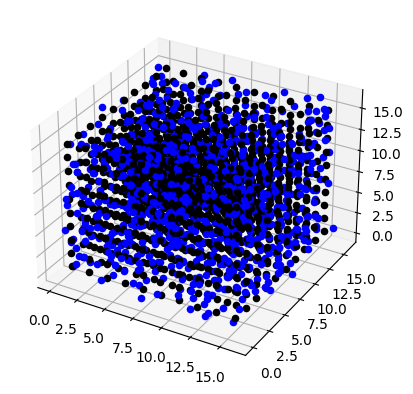

In [179]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for x in xHistory[0]:
    ax.scatter(*x,color='black')
for x in xHistory[-1]:
    ax.scatter(*x,color='blue')

In [180]:
U = []
for x in xHistory:
    U.append(LJ(x,1000))
E = []
for v in vHistory:
    E.append(np.linalg.norm(np.sum(v,axis=0),2)**2/2)

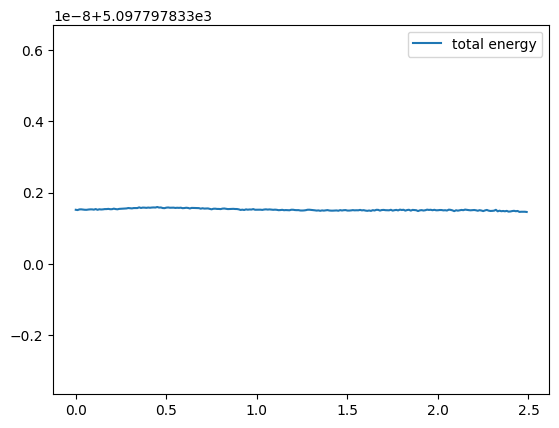

In [187]:
H = [x + y for x, y in zip(U, E)]
plt.plot(tHistory,H[:],label='total energy')
#plt.ylim(500,600)
plt.legend()

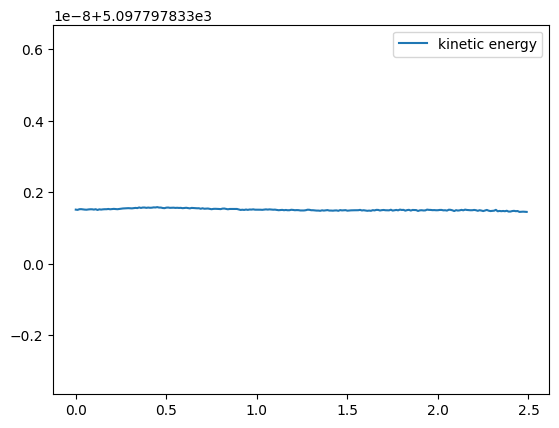

In [188]:
plt.plot(tHistory,E[:],label='kinetic energy')
#plt.ylim(400,1000)
plt.legend()

In [183]:
def VACF(v,nMD=3000):
    s = np.shape(v[0])[0]
    res = np.zeros((nMD,1))
    
    v0 = np.array([np.linalg.norm(v[0][j,:],2) for j in range(s)])

    for i in range(nMD):
        v_n = list()
        for k in range(s):
            v_n.append(np.linalg.norm(v[i][k,:],2))
        v_n = np.array(v_n)
        res[i] = np.mean(v0*v_n)/np.mean(v0*v0)
    return res

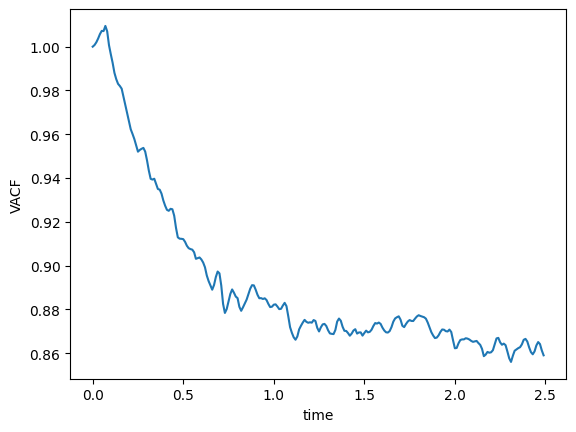

In [190]:
vcf = VACF(vHistory, nMD=250)
plt.plot(tHistory,vcf)
plt.xlabel('time')
plt.ylabel('VACF');

In [185]:
vx = vHistory[-1][:,0]

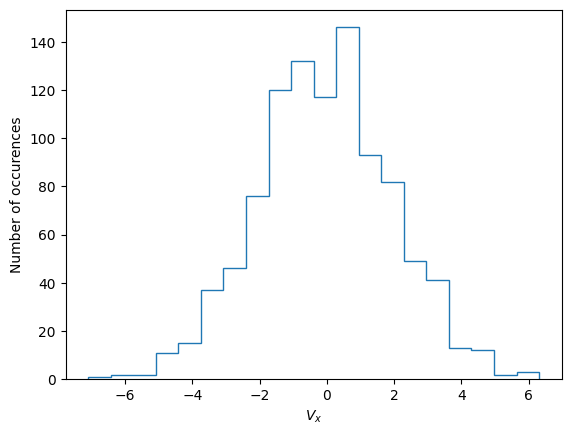

In [193]:

counts, bins = np.histogram(vx,bins=20)
plt.stairs(counts, bins)
plt.xlabel('$V_x$')
plt.ylabel('Number of occurences');

## Problem 2

$$
m\frac{dv}{dt} = -\alpha v +F(t)
$$

Multiplying by $e^{\frac{\alpha t}{m}}$ we can write it as:

$$
\frac{d}{dt}(v(t)e^{\frac{\alpha t}{m}}) = e^{\frac{\alpha t}{m}}\frac{F(t)}{m}
$$

which can be integrated from $t=-\infty$ to give:

$$
v(t) = \int_{-\infty}^{t} dt^{'}e^{\frac{-\alpha (t-t^{'})}{m}}\frac{F}{m}
$$

Then VAFC follows directly as

$$
<v(t)v(0)> = \int_{-\infty}^{t} dt^{'}\int_{-\infty}^{0}dt^{''}e^{\frac{-\alpha (t-t^{'}-t^{''})}{m}}\frac{<F(t^{'})F(t^{''})>}{m^2}=\int_{-\infty}^{t} dt^{'}\int_{-\infty}^{0}dt^{''}e^{\frac{-\alpha (t-t^{'}-t^{''})}{m}}\frac{a\delta (t^{'}-t^{''})}{m^2} = \int_{-\infty}^{0}dt^{''}e^{\frac{-\alpha (t-2t^{''}}{m}}\frac{a}{m^2} = \frac{a}{2m\alpha}e^{\frac{-\alpha t}{m}}
$$

since

$$
\frac{1}{2}m<v^2> = \frac{kT}{2}
$$

we get $a$

$$
a = 2\alpha kT
$$

and 

$$
<v(t)v(0)> = \frac{kT}{m}e^{\frac{-\alpha t}{m}}
$$

In [195]:
def distr(n):
    return np.random.normal(size=(n,1))

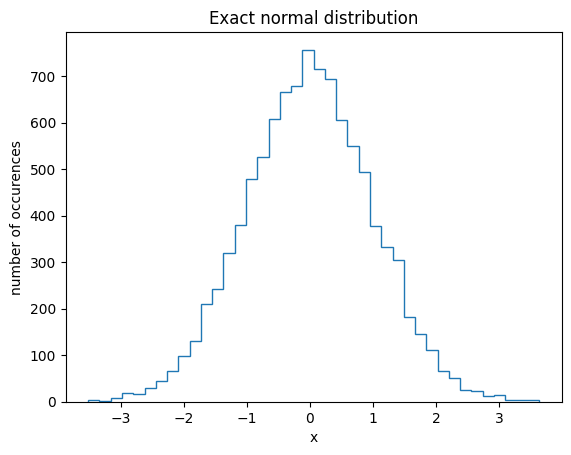

In [198]:
val = distr(10000)
counts, bins = np.histogram(val,bins=40)
plt.stairs(counts, bins)
plt.xlabel('x')
plt.ylabel('number of occurences')
plt.title('Exact normal distribution');

In [200]:
def clt(n,s):
    x = np.zeros((n,1))
    for i in range(s):
        x = x + np.random.uniform(size=(n,1))
    return x

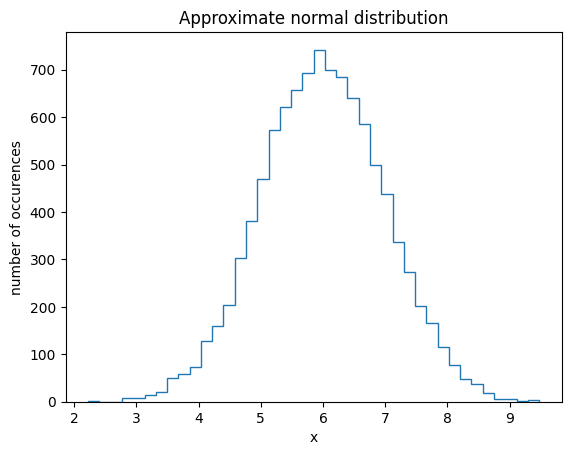

In [201]:
asd = clt(10000,12)
counts, bins = np.histogram(asd,bins=40)
plt.stairs(counts, bins)
plt.xlabel('x')
plt.ylabel('number of occurences')
plt.title('Approximate normal distribution');

In [203]:
val_app = distr(10000)

In [204]:
def update(Niter,N,dt):
    v0 = np.random.normal(size=(N,1))
    v = np.zeros((N,Niter))
    v[:,0] = v0[:,0]

    for i in range(1,Niter):
        v[:,i] = v[:,i-1] - v[:,i-1]*dt + (2*dt)**0.5*np.random.normal(size=(N,1))[:,0]
    return v

In [205]:
x = update(10000,100,0.001)

In [206]:
vcf = np.zeros((10000,1))
for i in range(10000):
    vcf[i] = np.mean(x[:,0]*x[:,i])/np.mean(x[:,0]*x[:,0])

In [207]:
def vcf_t(x):
    return np.exp(-x)
y = np.arange(0,10000*0.001,0.001)

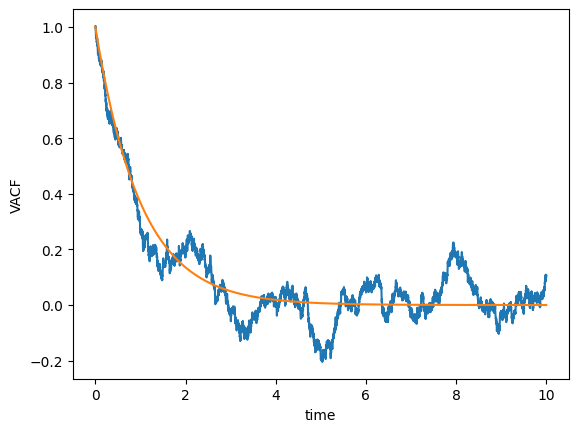

In [209]:
plt.plot(0.001*np.arange(10000),vcf)
plt.plot(0.001*np.arange(10000),vcf_t(y))
plt.xlabel('time')
plt.ylabel('VACF');

## Problem 3

In [24]:
from scipy.linalg import cholesky, norm

In [85]:
def func1(x,a=2,N=100):
    A = np.ones((N,1))
    A[:,0] = np.exp(-a*np.abs(x))
    return A

def func2(x,a=2,N=100):
    A = np.ones((N,1))
    A[:,0] = np.exp(-a*np.abs(x)**2)
    return A
    
def update_noise(Niter,N=100,lmbd=1e-8):
    sigma = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            sigma[i,j] = N - np.abs(i-j)
    
    sigma +=lmbd*np.eye(N)
    
    C = cholesky(sigma)
    x = np.random.normal(size=(N,Niter))
    y = np.matmul(C.T,x)
    
    return y

def integral(dt,Niter=500,N=100,a=2,f=func1):
    G = np.zeros((N,Niter))
    for i in range(Niter):
        G[:,i] = f(dt*i,N=N)[:,0] 
    
    return G

def update(Niter,N,dt,a=2,f=func1):
    v0 = np.random.uniform(size=(N,1))
    v = np.zeros((N,Niter))
    v[:,0] = v0[:,0]
    noise = update_noise(Niter,N)
    t_history = np.zeros((Niter,1))
    t_history[0] = 0
    G = integral(dt,Niter,N,a,f)
    n = np.shape(G)[1]
    for i in range(1,Niter):
        t_history[i] = t_history[i-1]+dt
        S = np.zeros((N,1))
        
        for j in range(i):
            S[:,0] = S[:,0]+G[:,i-j]*v[:,j] 
        v[:,i] = v[:,i-1] - S[:,0]*dt + (2*dt)**0.5*noise[:,i-1]
    return v,t_history

In [86]:
asd,t = update(500,100,0.1,f=func1)

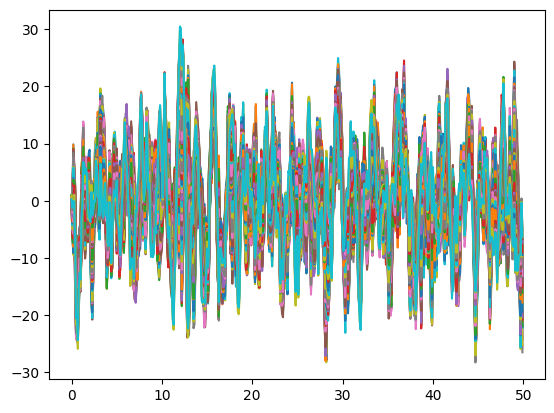

In [87]:
for i in range(100):
    plt.plot(t,asd[i,:])

In [88]:
vcf_2 = np.zeros((500,1))
for i in range(500):
    vcf_2[i] = np.mean(asd[:,0]*asd[:,i])/np.mean(asd[:,0]*asd[:,0])

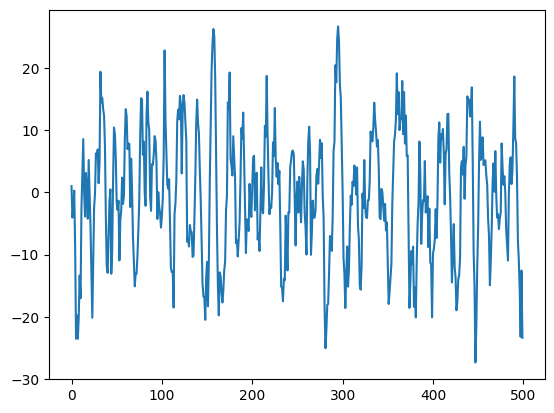

In [89]:
plt.plot(np.arange(500),vcf_2)

$$
M\frac{d}{dt}\frac{<v(0)v(t)>}{<v^2(0)>} = -\int_0^t G(t-\tau)\frac{<v(0)v(\tau)>}{<v^2(0)>}d\tau 
$$

$$
M\mathcal{L}[\frac{d}{dt}K_v(t)] = \int_0^\infty e^{-st}\frac{d}{dt}K_v(t)dt = -K_v(0) + s\hat K_v(s) = s\hat K_v(s) - 1 
$$

$$
-\mathcal{L}[\int_0^t G(t-\tau)\frac{<v(0)v(\tau)>}{<v^2(0)>}d\tau] =  -\int_0^\infty e^{-st}e^{-b|t|}dt\int_0^\infty e^{-s\tau}K_v(\tau)d\tau = -\frac{\hat K_v(s)}{b+s}
$$

$$
s\hat K_v(s) - 1  = -\frac{\hat K_v(s)}{b+s}
$$

$$
s\hat K_v(s) = \frac{b+s -\hat K_v(s) }{b+s}
$$

$$
(b+s)s\hat K_v(s) = b+s - \hat K_v(s)
$$

$$
\hat K_v(s) = \frac{b+s}{s(b+s)+1} = \frac{1}{s+\frac{1}{b+s}}
$$

$$
K_v(t) = \mathcal{L^{-1}}[\hat K_v(s)] = \mathcal{L^{-1}}[\frac{1}{s+\frac{1}{b+s}}] = e^{-\frac{bt}{2}}\left (\frac{b\sinh(\frac{1}{2}t\sqrt{b^2-4})}{\sqrt{b^2-4}} + \cosh(\frac{1}{2}t\sqrt{b^2-4})\right)
$$

## Problem 4


$$
\chi_{AB}^{''}(\omega) =  \frac{\omega}{2kT}\hat K_{AB}^{cl}(\omega)
$$


$$
K_{AB}^{cl}(t) = <A(t)B(0)>
$$

$$
<A(t)B(0)> = -<A(0)B(-t)>
$$

$$
<A(0)B(t)> = C\exp \left({\frac{-|t|}{\tau}}\right)
$$

$$
<A(t)B(0)> = -C\exp \left({\frac{-|t|}{\tau}}\right)
$$

$$
\chi_{AB}^{''}(\omega) =  \frac{\omega}{2kT}\mathcal{F}\left[-C\exp \left({\frac{-|t|}{\tau}}\right)\right](\omega)
$$

$$
\chi_{AB}^{''}(\omega) = -\frac{\omega\tau C}{(\tau^2\omega^2+1)(k_BT)}
$$